In [1]:
import numpy as np
import pandas as pd
from numpy.random import default_rng, SeedSequence
import scipy.stats as sps
import matplotlib.pyplot as plt
from scipy.stats import norm
import warnings

sq = SeedSequence()
seed = sq.entropy
rng = default_rng(sq)

### Outils : générateur de browniens, de trajectoires BS, formule de payoff, formules fermées de BS

In [2]:
def brownian_1d(n_times: int, n_paths: int, 
                final_time: float=1.0, 
                increments: bool=False, 
                random_state: np.random.Generator=rng) -> np.array:
    """Simulate paths of standard Brownian motion
    Args:
        n_times: Number of timesteps
        n_paths: Number of paths 
        final_time: Final time of simulation
        increments: If `True` the increments of the paths are returned.
        random_state: `np.random.Generator` used for simulation
    Returns:
        `np.array` of shape `(n_times+1, n_paths)` containing the paths if the argument `increments` is `False`
        `np.array` of shape `(n_times, n_paths)` containing the increments if the argument `increments` is `True`
    """
    dB = np.sqrt(final_time / n_times) * random_state.standard_normal((n_times, n_paths))
    if increments:
        return dB
    else:
        brownian = np.zeros((n_times+1, n_paths))
        brownian[1:] = np.cumsum(dB, axis=0)
        return brownian

In [3]:
def black_scholes_1d(n_times: int, n_paths: int, 
                     final_time: float=1.0, 
                     random_state: np.random.Generator=rng, *,
                     init_value: float,
                     r: float, sigma: float) -> np.array:
    """Simulate paths of Black-Scholes process
    Args:
        n_times: Number of timesteps
        n_paths: Number of paths 
        final_time: Final time of simulation
        init_value: `S0`
        r: Interest rate
        sigma: Volatility
        random_state: `np.random.Generator` used for simulation
    Returns:
        `np.array` of shape `(n_times+1, n_paths)` containing the paths 
    """
    Bt = brownian_1d(n_times, n_paths)
    times = np.arange(n_times+1)*(1/n_times)
    t = times[:, np.newaxis]
    St = init_value * np.exp((r - 0.5*sigma**2)*t + sigma*Bt)
    return St

In [4]:
# une fonction BS pour un payoff qui n'est pas path-dependent (offre plus de liberté pour le choix des gaussiennes dans la fonction)
def BS(x,r,sigma,T,N):
    """ args :
            x=spot
            r=interest rate
            sigma=volatility
            T=maturity
            N=simulated standard normal random variable
    """
    return  x*np.exp((r-(sigma**2)/2)*T+sigma*np.sqrt(T)*N)

# une fonction de payoff du call et sa dérivée par rapport à S_T
def payoff_call(S,r,T,K): return np.exp(-r*T)*np.maximum(S-K,0)
def payoff_put(S,r,T,K): return np.exp(-r*T)*np.maximum(K-S,0)

def call_derive(S,r,T,K): return np.exp(-r*T)*np.where(S>K,1,0)

In [5]:
def monte_carlo(sample, proba = 0.95):
    mean = np.mean(sample)
    var = np.var(sample, ddof=1)
    alpha = 1 - proba 
    quantile = norm.ppf(1 - alpha/2)  # fonction quantile 
    ci_size = quantile * np.sqrt(var / sample.size)
    return (mean, var, mean - ci_size, mean + ci_size)

In [6]:
# Les formules fermées de Black-Scholes pour vérifier nos méthodes de MC

def d1(spot, t, r, sigma, strike):
    return (np.log(spot / strike) + t * (r + 0.5*sigma**2)) / (sigma * np.sqrt(t))

def d2(spot, t, r, sigma, strike):
    return d1(spot, t, r, sigma, strike) - sigma * np.sqrt(t)

def price_call_BS(spot, t, r, sigma, strike):
    d1_ = d1(spot, t, r, sigma, strike)
    d2_ = d2(spot, t, r, sigma, strike)
    return spot * norm.cdf(d1_) - strike * np.exp(-r * t) * norm.cdf(d2_)

def delta_BS(spot, t, r, sigma, strike):
    d1_ = d1(spot, t, r, sigma, strike)
    return norm.cdf(d1_)

### Pour tester nos fonctions : Pricing MC standard

In [7]:
# Fixons les paramètres

S0 = 100
T=1
K=100
r, sigma = 0.04, 0.20

In [8]:
Ms = 10**np.arange(3, 8)
results = pd.DataFrame(index=['Mean', 'Var', 'Lower', 'Upper'], columns=Ms)
for M in Ms:
    gaussiennes = rng.standard_normal(M)
    payoffs=payoff_call(BS(x=S0,r=r,sigma=sigma,T=T,N=gaussiennes),r=r,T=T,K=K)
    results[M] = monte_carlo(payoffs)
results

,1000,10000,100000,1000000,10000000
Mean,9.712122,10.042327,9.886496,9.926891,9.926359
Var,189.080850,207.154298,206.833680,208.259954,207.870333
Lower,8.859863,9.760233,9.797359,9.898607,9.917422
Upper,10.564382,10.324422,9.975634,9.955176,9.935295


In [9]:
price_call_BS(S0, T, r, sigma, K)

9.925053717274437

# I. Sensibilités

## A. Payoff Call vanille

On cherche à calculer le prix du delta d'un Call vanille à l'aide d'une méthode de monte carlo. Ici, le payoff n'est pas path-dependent

$$
\Phi'(x)=\mathbb E(\phi'(X_T^x)\frac{X_T^x}{x})=\mathbb E(\phi(X_T^x)\frac{W_T}{x \sigma T})
$$

### 1. Méthode 1

Nous allons comparer :
$$
\mathbb E(\phi'(X_T^x)\frac{X_T^x}{x}) \qquad \text{(sans réduction de variance)}
$$
et :
$$
\Phi'(x)=\mathbb E([\phi'(X_T^x)-\phi'(xe^{rT})]\frac{X_T^x}{x})+\phi'(xe^{rT})e^{rT} \qquad \text{(variable de contrôle méthode 1)}
$$

In [10]:
# première méthode, sans réduction de variance

Ms = 10**np.arange(3, 9)
results1a = pd.DataFrame(index=['Mean', 'Var', 'Lower', 'Upper'], columns=Ms)
for M in Ms:
    gaussiennes = rng.standard_normal(M)
    payoffs=call_derive(BS(x=S0,r=r,sigma=sigma,T=T,N=gaussiennes),r=r,T=T,K=K)*BS(x=S0,r=r,sigma=sigma,T=T,N=gaussiennes)/S0
    results1a[M] = monte_carlo(payoffs)
results1a

,1000,10000,100000,1000000,10000000,100000000
Mean,0.612950,0.624501,0.618376,0.618258,0.617865,0.617916
Var,0.335005,0.339855,0.338327,0.337866,0.337850,0.337855
Lower,0.577077,0.613075,0.614771,0.617119,0.617504,0.617802
Upper,0.648824,0.635927,0.621981,0.619397,0.618225,0.618030


In [11]:
# formule fermée
delta_BS(S0, T, r, sigma, K)

0.6179114221889526

La simulation semble converger vers le bon prix.

In [12]:
warnings.filterwarnings("ignore")

# méthode 1, avec réduction de variance

Ms = 10**np.arange(3, 9)
results1b = pd.DataFrame(index=['Mean', 'Var', 'Lower', 'Upper'], columns=Ms)
for M in Ms:
    gaussiennes = rng.standard_normal(M)
    payoffs=(call_derive(BS(x=S0,r=r,sigma=sigma,T=T,N=gaussiennes),r=r,T=T,K=K)-call_derive(S0*np.exp(r*T),r=r,T=T,K=K))*BS(x=S0,r=r,sigma=sigma,T=T,N=gaussiennes)/S0
    results1b[M] = monte_carlo(payoffs)
    results1b[M].iloc[0]+=call_derive(S0*np.exp(r*T),r=r,T=T,K=K)*np.exp(r*T)
    results1b[M].iloc[2:]+=call_derive(S0*np.exp(r*T),r=r,T=T,K=K)*np.exp(r*T)
results1b

,1000,10000,100000,1000000,10000000,100000000
Mean,0.640032,0.623406,0.619400,0.618143,0.618080,0.617891
Var,0.173143,0.173994,0.175063,0.175068,0.175098,0.175142
Lower,0.614242,0.615231,0.616807,0.617323,0.617821,0.617809
Upper,0.665822,0.631582,0.621993,0.618963,0.618339,0.617973


On constate une réduction de variance significante par rapport à notre première simulation.

### 2. Méthode 2

Nous allons comparer :
$$
\mathbb E(\phi(X_T^x)\frac{W_T}{x \sigma T}) \qquad \text{(sans réduction de variance, méthode 2)}
$$
et :
$$
\Phi'(x)=\mathbb E([\phi(X_T^x)-\phi(xe^{rT})]\frac{W_T}{x \sigma T}) \qquad \text{(variable de contrôle méthode 2)}
$$

In [13]:
Ms = 10**np.arange(3, 9)
results2a = pd.DataFrame(index=['Mean', 'Var', 'Lower', 'Upper'], columns=Ms)
for M in Ms:
    gaussiennes = rng.standard_normal(M)
    payoffs=payoff_call(BS(x=S0,r=r,sigma=sigma,T=T,N=gaussiennes),r=r,T=T,K=K)*np.sqrt(T)*gaussiennes/(S0*sigma*T)
    results2a[M] = monte_carlo(payoffs)
results2a

,1000,10000,100000,1000000,10000000,100000000
Mean,0.607158,0.606195,0.615235,0.618315,0.618703,0.617868
Var,1.961407,2.080481,2.086038,2.071439,2.077536,2.074589
Lower,0.520356,0.577925,0.606284,0.615494,0.617809,0.617585
Upper,0.693960,0.634465,0.624187,0.621135,0.619596,0.618150


In [14]:
Ms = 10**np.arange(3, 9)
results2b = pd.DataFrame(index=['Mean', 'Var', 'Lower', 'Upper'], columns=Ms)
for M in Ms:
    gaussiennes = rng.standard_normal(M)
    payoffs=(payoff_call(BS(x=S0,r=r,sigma=sigma,T=T,N=gaussiennes),r=r,T=T,K=K)-payoff_call(S0*np.exp(r*T),r,T,K))*gaussiennes/(S0*sigma*np.sqrt(T))
    results2b[M] = monte_carlo(payoffs)
results2b

,1000,10000,100000,1000000,10000000,100000000
Mean,0.641975,0.607928,0.615667,0.617265,0.617997,0.617781
Var,1.754384,1.742841,1.668815,1.712629,1.720296,1.720973
Lower,0.559882,0.582053,0.607661,0.614700,0.617184,0.617524
Upper,0.724069,0.633803,0.623674,0.619830,0.618810,0.618038


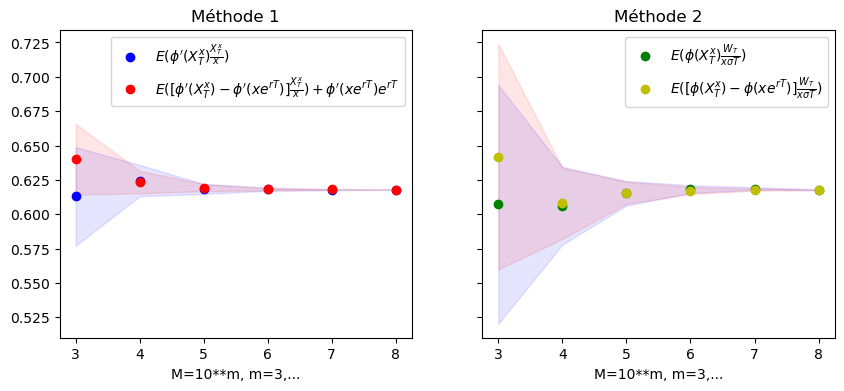

In [15]:
logM = np.log10(Ms)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharey=True)

ax1.plot(logM, results1a.iloc[0], 'bo', label=r'''$E(\phi'(X_T^x) \frac{X_T^x}{x})$''')
ax1.fill_between(logM, results1a.iloc[2], results1a.iloc[3], color='b', alpha=0.1)

ax1.plot(logM, results1b.iloc[0], 'ro', label=r'''$E([\phi'(X_T^x)-\phi'(xe^{rT})]\frac{X_T^x}{x})+\phi'(xe^{rT})e^{rT}$''')
ax1.fill_between(logM, results1b.iloc[2], results1b.iloc[3], color='r', alpha=0.1)

ax1.set_xlabel('M=10**m, m=3,...')
ax1.set_title('Méthode 1')
ax1.legend()

ax2.plot(logM, results2a.iloc[0], 'go', label=r'$E(\phi(X_T^x) \frac{W_T}{x \sigma T})$')
ax2.fill_between(logM, results2a.iloc[2], results2a.iloc[3], color='b', alpha=0.1)

ax2.plot(logM, results2b.iloc[0], 'yo', label=r'$E([\phi(X_T^x)-\phi(xe^{rT})]\frac{W_T}{x \sigma T})$')
ax2.fill_between(logM, results2b.iloc[2], results2b.iloc[3], color='r', alpha=0.1)

ax2.set_xlabel('M=10**m, m=3,...')
ax2.set_title('Méthode 2')
ax2.legend()

plt.show()

### 3. Comparaison des variances en fonction de la maturité

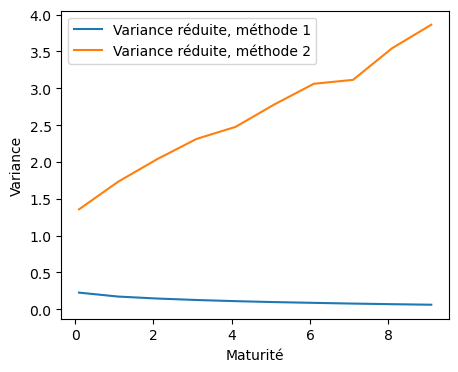

In [16]:
maturites=np.arange(0.1,10)
results = pd.DataFrame(index=['1e methode','2e methode'], columns=maturites)
M=10**5
for T in maturites:
    gaussiennes = rng.standard_normal(M)
    payoffs=(call_derive(BS(x=S0,r=r,sigma=sigma,T=T,N=gaussiennes),r=r,T=T,K=K)-call_derive(S0*np.exp(r*T),r=r,T=T,K=K))*BS(x=S0,r=r,sigma=sigma,T=T,N=gaussiennes)/S0
    results[T].iloc[0] = monte_carlo(payoffs)[1]
    gaussiennes = rng.standard_normal(M)
    payoffs=(payoff_call(BS(x=S0,r=r,sigma=sigma,T=T,N=gaussiennes),r=r,T=T,K=K)-payoff_call(S0*np.exp(r*T),r,T,K))*gaussiennes/(S0*sigma*np.sqrt(T))
    results[T].iloc[1] = monte_carlo(payoffs)[1]

fig, ax = plt.subplots(figsize=(5, 4))

ax.plot(maturites, results.iloc[0],label='Variance réduite, méthode 1')
ax.plot(maturites, results.iloc[1], label='Variance réduite, méthode 2')
ax.legend()
ax.set_xlabel('Maturité')
ax.set_ylabel('Variance')
plt.show()

Ici, la méthode 1 a une variance systématiquement plus faible que la méthode 2, quelle que soit la maturité choisie. De plus, la variance de la seconde méthode augmente lorsque la maturité augmente. C'est dû à la forme du payoff du call standard qui tend vers l'infini quand la valeur du sous-jacent diverge. Testons la même méthode avec un payoff borné : une option digitale par exemple.

## B. Payoff Binaire (Call spread)

Il s'agit de faire les mêmes simulations que précédemment mais pour un call digital. Or le payoff étant discontinu, on réplique statiquement le payoff par un call spread :
- On achète (1/$\epsilon$) Calls de Strike K-$\epsilon$.
- On vend (1/$\epsilon$) Calls de Strike K.

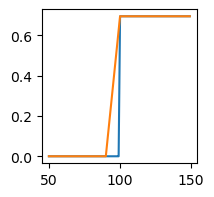

In [17]:
def payoff_spread(S,r,T,K,sprd): return (1/sprd)*payoff_call(S,r,T,K-sprd)-(1/sprd)*payoff_call(S,r,T,K)
def spread_derive(S,r,T,K,sprd): return np.exp(-r*T)*np.where(S>K-sprd,1/sprd,0)*np.where(S<K,1/sprd,0)

plt.figure(figsize=(2,2))
S=np.arange(50,150)
plt.plot(S,payoff_spread(S,r,T,K,0.1))
plt.plot(S,payoff_spread(S,r,T,K,10))

In [18]:
def var_mat(spread):
    maturites=np.arange(0.1,10,0.2)
    results = pd.DataFrame(index=['1e methode','2e methode'], columns=maturites)
    M=10**5
    for T in maturites:
        gaussiennes = rng.standard_normal(M)
        payoffs=(spread_derive(BS(x=S0,r=r,sigma=sigma,T=T,N=gaussiennes),r=r,T=T,K=K,sprd=spread)-spread_derive(S0*np.exp(r*T),r=r,T=T,K=K,sprd=spread))*BS(x=S0,r=r,sigma=sigma,T=T,N=gaussiennes)/S0
        results[T].iloc[0] = monte_carlo(payoffs)[1]
        gaussiennes = rng.standard_normal(M)
        payoffs=(payoff_spread(BS(x=S0,r=r,sigma=sigma,T=T,N=gaussiennes),r=r,T=T,K=K,sprd=spread)-payoff_spread(S0*np.exp(r*T),r,T,K,sprd=spread))*gaussiennes/(S0*sigma*np.sqrt(T))
        results[T].iloc[1] = monte_carlo(payoffs)[1]

    fig, ax = plt.subplots(figsize=(5, 4))

    ax.plot(maturites, results.iloc[0],label='Variance réduite, méthode 1')
    ax.plot(maturites, results.iloc[1], label='Variance réduite, méthode 2')
    ax.legend()

    ax.set_xlabel('Maturité')
    ax.set_ylabel('Variance')
    plt.show()

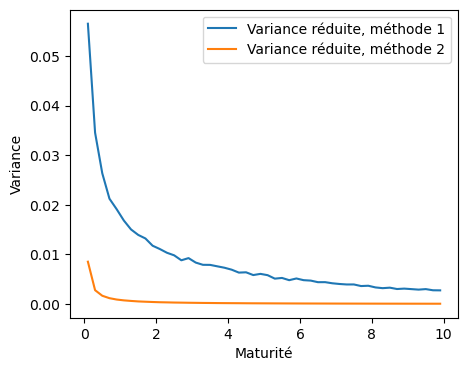

In [19]:
var_mat(spread=1)

Cette fois-ci, la variance de la second méthode de réduction est bien décroissante avec la maturité. C'est ce que l'on espérait en faisant apparaîte $T$ au dénominateur. De plus, la seconde méthode de réduction est meilleure pour ce payoff digital, mais attention, cela dépend tout de même de la valeur du spread choisi.

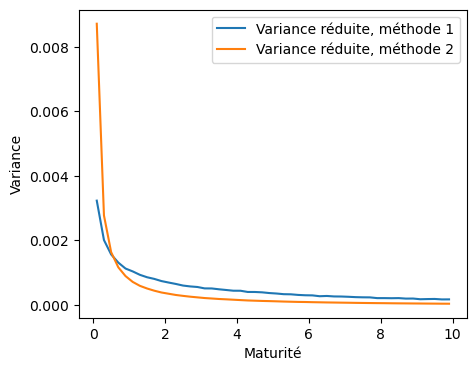

In [20]:
var_mat(spread=2.5)